In [17]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt

### Кастомный класс датасета

In [18]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.root_dir + '/' + self.data_frame.iloc[idx, 0]
        image = Image.open(img_name).convert('RGB')

        label = int(self.data_frame.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

### Пути к лейблам и картинкам

In [19]:
csv_file = './ordered_labels_paths.csv'
root_dir = './images/'

### Код который считает мат ожидания и отклонения для всех картинок, используется для нормализации

In [20]:
import numpy as np

# Работает долго, поэтому закомментирован
# 
# mean_values = []
# std_values = []
# 
# image_paths = [f'./images/{i}.png' for i in range(3516)]

# for image_path in image_paths:
#     i += 1
#     print(f'done {i} images')
#     img = Image.open(image_path)
#     img_array = np.array(img) / 255.0  # Нормализация до [0, 1]
#     mean_values.append(img_array.mean(axis=(0, 1))[0:3])
#     std_values.append(img_array.std(axis=(0, 1))[0:3])
 
# mean = np.mean(mean_values, axis=0)
# std = np.mean(std_values, axis=0)

# print("Средние значения:", mean)
# print("Стандартные отклонения:", std)

# Средние значения: [0.34174714 0.32189642 0.22421347]
# Стандартные отклонения: [0.15052124 0.14424481 0.12172569]

# Посчитанные значения
mean = np.array([0.34174714, 0.32189642, 0.22421347])
std = np.array([0.15052124, 0.14424481, 0.12172569])

### Преобразования

In [21]:
# Кастомное преобразование, обрезает картинку до квадрата по меньшей стороне
def min_square_crop(img:Image) -> Image:
    h, w = img.shape[1:3]
    new_size = min(h, w)
    h_start = (h - new_size) // 2
    w_start = (w - new_size) // 2
    new_image = img[:, h_start: h_start + new_size, w_start: w_start + new_size]
    return new_image

# Помимо стандартных преобразований делаем небольшой поворот и отражения, чтобы повысить изменчивость картинок
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Lambda(min_square_crop),
    transforms.Resize((128, 128)),
])


# Создаем экземпляр датасета
custom_dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

### Классы

In [59]:
classes = ['Zygiella x-notata',
 'Araneidae',
 'Clubiona',
 'Theridiidae',
 'Socca pustulosa',
 'Dolophones',
 'Latrodectus hasselti',
 'Laetesia raveni',
 'Clynotis severus',
 'Nephila pilipes',
 'Tamopsis brisbanensis',
 'Trichonephila edulis',
 'Servaea',
 'Tetragnatha',
 'Thomisidae',
 'Hortophora',
 'Lycosidae',
 'Plebs eburnus',
 'Helpis minitabunda',
 'Salticidae',
 'Copa kabana',
 'Araneinae',
 'Austracantha minax',
 'Opisthoncus',
 'Sidymella',
 'Namandia',
 'Arkys curtulus',
 'Arkys alatus',
 'Australomisidia',
 'Thwaitesia nigronodosa',
 'Paraphilaeus daemeli',
 'Megadolomedes trux',
 'Astilodes mariae',
 'Telaprocera maudae',
 'Tamopsis fickerti',
 'Tamopsis tweedensis',
 'Badumna',
 'Servaea villosa',
 'Euryopis',
 'Toxopsoides erici',
 'Oxyopes',
 'Opisthoncus quadratarius',
 'Heteropoda',
 'Pungalina',
 'Stephanopis carcinoides',
 'Stephanopis barbipes',
 'Sidymella rubrosignata',
 'Stephanopis altifrons',
 'Helpis kenilworthi',
 'Menneus aussie',
 'Janula bicornis',
 'Tharrhalea',
 'Salsa',
 'Maratus griseus',
 'Tamopsis brachycauda']

### Проверяем что все отображается

C:\Users\tosha\anaconda3\envs\convneural\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


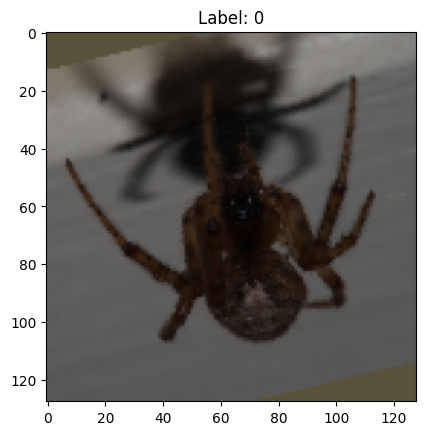

In [22]:
from torchvision import transforms
import matplotlib.pyplot as plt

index_to_display = 0

image, label = custom_dataset[index_to_display]

inv_transform = transforms.Compose([
    transforms.Normalize(mean=-mean/std, std=1/std),
])

image = inv_transform(image)
image = transforms.ToPILImage()(image)

plt.imshow(image)
plt.title(f"Label: {label}")
plt.show()


### Делаем обучающий и тестовый датасеты

In [24]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size

train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, shuffle=False)

### Обертки для перемещения модели и данных на нужное устройство

In [25]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [26]:
device = 'cuda'
# device = 'cpu'

### Параметры модели

In [27]:
batch_size = 32
lr = 0.0001

### Создаем данные и модель на нужном устройстве

In [28]:
train_dataloader = DeviceDataLoader(
    DataLoader(train_dataset, batch_size=batch_size), device)
test_dataloader =  DeviceDataLoader(DataLoader(test_dataset), device)

### В качестве основы возьмем resnet50

In [29]:
from torchvision import models
import torch.nn as nn

net = models.resnet50(pretrained=True)
    
for param in net.parameters():
    param.requires_grad = False
    
net.fc = nn.Linear(net.fc.in_features, 55)
net = to_device(net, device)

C:\Users\tosha\anaconda3\envs\convneural\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tosha\anaconda3\envs\convneural\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
import torch.optim as optim

# Определяем функцию потерь, метод оптимизации и планировщик
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=2e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.2, verbose=True)
# Определение функции для вычисления точности
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

# Сюда будем заносить скоры модели в зависимости от эпохи
train_accuracies = []
test_accuracies = []

### Функции обучения и рисования графиков

In [31]:
import time

def train(iters):
    # Сам процесс обучения
    for epoch in range(iters):
        start_time = time.time()
        # Переводим модель в режим обучения 
        net.train()
        total_train_accuracy = 0.0
        for images, labels in train_dataloader:
            # Применяем модель к данным
            outputs = net(images)
            # Вычисляем функцию потерь
            loss = criterion(outputs, labels)
    
            # Обнуляем градиент
            optimizer.zero_grad()
            # Вычисляем градиенты по параметрам
            loss.backward()
            # Обновляем параметры
            optimizer.step()
            # Добавляем скор на пачке к общему скору
            total_train_accuracy += accuracy(outputs, labels)
    
        # Считаем общий скор и добавляем в массив
        average_train_accuracy = total_train_accuracy / len(train_dataloader)
        train_accuracies.append(average_train_accuracy)
    
        # Переводим модель в режим оценки и считаем скор на тесте
        net.eval()
        total_test_accuracy = 0.0
        with torch.no_grad():
            for images, labels in test_dataloader:
                outputs = net(images)
                total_test_accuracy += accuracy(outputs, labels)
        # Получаем тестовый скор
        average_test_accuracy = total_test_accuracy / len(test_dataloader)
        test_accuracies.append(average_test_accuracy)
        # Печатаем результаты итерации
        scheduler.step(average_test_accuracy)
        execution_time = time.time() - start_time
        print(f'{(epoch + 1)/iters*100:.2f}%, '
              f'train_acc: {average_train_accuracy*100:.2f}%, '
              f'test_acc: {average_test_accuracy*100:.2f}%, '
              f'time per iter: {execution_time:.2f}')

def plot_acc():
    # Построение графика
    n_points = len(train_accuracies)
    epochs_range = range(1, n_points+1)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy Over Epochs')
    plt.legend()
    plt.show()

In [32]:
train(55)

1.82%, train_acc: 10.71%, test_acc: 20.60%, time per iter: 113.22
3.64%, train_acc: 19.63%, test_acc: 25.14%, time per iter: 112.08
5.45%, train_acc: 25.51%, test_acc: 28.55%, time per iter: 112.49
7.27%, train_acc: 29.81%, test_acc: 30.54%, time per iter: 112.78
9.09%, train_acc: 33.83%, test_acc: 32.81%, time per iter: 112.01
10.91%, train_acc: 36.51%, test_acc: 34.52%, time per iter: 111.98
12.73%, train_acc: 39.64%, test_acc: 36.08%, time per iter: 112.79
14.55%, train_acc: 42.27%, test_acc: 38.64%, time per iter: 110.75
16.36%, train_acc: 44.09%, test_acc: 38.21%, time per iter: 109.74
18.18%, train_acc: 46.68%, test_acc: 38.64%, time per iter: 106.71
20.00%, train_acc: 47.32%, test_acc: 40.91%, time per iter: 107.73
21.82%, train_acc: 47.53%, test_acc: 40.62%, time per iter: 112.92
23.64%, train_acc: 50.06%, test_acc: 40.48%, time per iter: 111.90
25.45%, train_acc: 49.72%, test_acc: 41.05%, time per iter: 108.38
27.27%, train_acc: 50.86%, test_acc: 41.05%, time per iter: 107.59


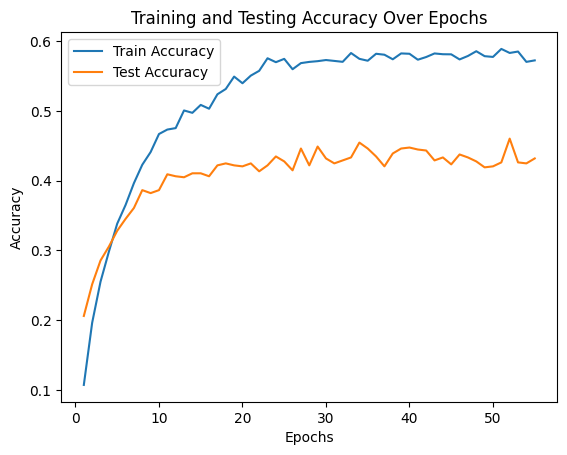

In [33]:
plot_acc()

##### Мои модели давали максимум 40% точности на тесте

### Top-k accuracy

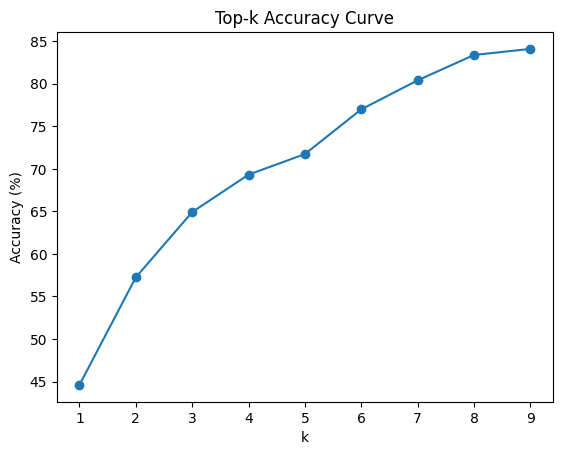

In [34]:
def top_k_accuracy(output, target, k=1):
    with torch.no_grad():
        _, pred = output.topk(k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        return correct_k.mul_(100.0 / target.size(0)).item()

model = net
dataloader = test_dataloader

k_values = list(range(1, 10))  # Пример: top-1 до top-5
accuracy_values = []

with torch.no_grad():
    for k in k_values:
        total_accuracy = 0.0
        total_samples = 0

        for inputs, targets in dataloader:
            outputs = model(inputs)
            accuracy = top_k_accuracy(outputs, targets, k=k)
            total_accuracy += accuracy * targets.size(0)
            total_samples += targets.size(0)

        final_accuracy = total_accuracy / total_samples
        accuracy_values.append(final_accuracy)

# Построение графика
plt.plot(k_values, accuracy_values, marker='o')
plt.title('Top-k Accuracy Curve')
plt.xlabel('k')
plt.ylabel('Accuracy (%)')
plt.show()

In [35]:
import pickle

with open('net.pkl', 'wb') as f:
    pickle.dump(net, f)

In [36]:
accuracy_values

[44.60227272727273,
 57.24431818181818,
 64.91477272727273,
 69.31818181818181,
 71.73295454545455,
 76.98863636363636,
 80.39772727272727,
 83.38068181818181,
 84.0909090909091]

In [95]:
cpu_net = to_device(net, 'cpu')
def test_sample(sample_id):
    im, lb = test_dataset[sample_id]
    cpu_net.eval()
    with torch.no_grad():
        out = cpu_net(im.unsqueeze(0))
        _, predicted = torch.max(out, 1)
    
    df = pd.DataFrame()
    df['Classes'] = np.array(classes)
    df['Predictions'] = out[0].numpy()
    display(df)
    
    plt.imshow(transforms.ToPILImage()(inv_transform(im)))
    plt.title(f"True: {classes[lb]}, Predicted: {classes[predicted]}")
    plt.show()

C:\Users\tosha\anaconda3\envs\convneural\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


,Classes,Predictions
0,Zygiella x-notata,-3.540223
1,Araneidae,-3.427830
2,Clubiona,-3.288856
3,Theridiidae,-4.993487
4,Socca pustulosa,-3.228010
5,Dolophones,-4.978406
6,Latrodectus hasselti,-6.380507
7,Laetesia raveni,-5.376885
8,Clynotis severus,-3.463484
9,Nephila pilipes,-6.343751


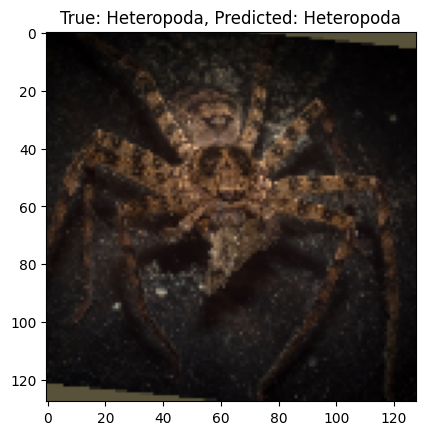

In [100]:
test_sample(0)

C:\Users\tosha\anaconda3\envs\convneural\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


,Classes,Predictions
0,Zygiella x-notata,-0.920664
1,Araneidae,-1.499980
2,Clubiona,-2.898596
3,Theridiidae,-1.375978
4,Socca pustulosa,-2.733851
5,Dolophones,-2.547713
6,Latrodectus hasselti,-1.746652
7,Laetesia raveni,-1.802281
8,Clynotis severus,-2.012792
9,Nephila pilipes,-2.193107


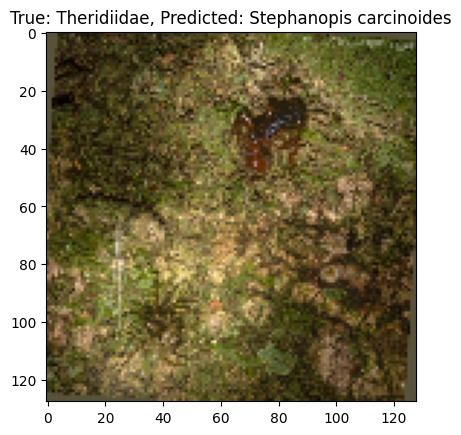

In [113]:
test_sample(1)

C:\Users\tosha\anaconda3\envs\convneural\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


,Classes,Predictions
0,Zygiella x-notata,-1.779316
1,Araneidae,-1.637069
2,Clubiona,-2.650246
3,Theridiidae,-1.655394
4,Socca pustulosa,-3.444673
5,Dolophones,-3.600559
6,Latrodectus hasselti,-3.065222
7,Laetesia raveni,-0.347856
8,Clynotis severus,-4.789385
9,Nephila pilipes,-3.792423


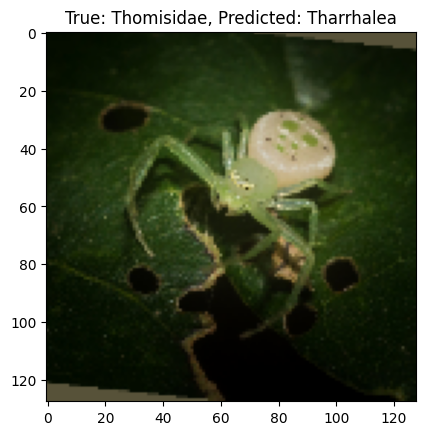

In [103]:
test_sample(5)

C:\Users\tosha\anaconda3\envs\convneural\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


,Classes,Predictions
0,Zygiella x-notata,-2.060750
1,Araneidae,-2.183492
2,Clubiona,-3.487962
3,Theridiidae,-2.116585
4,Socca pustulosa,-2.242919
5,Dolophones,-2.907181
6,Latrodectus hasselti,-2.556376
7,Laetesia raveni,-2.857751
8,Clynotis severus,-1.864932
9,Nephila pilipes,-3.108772


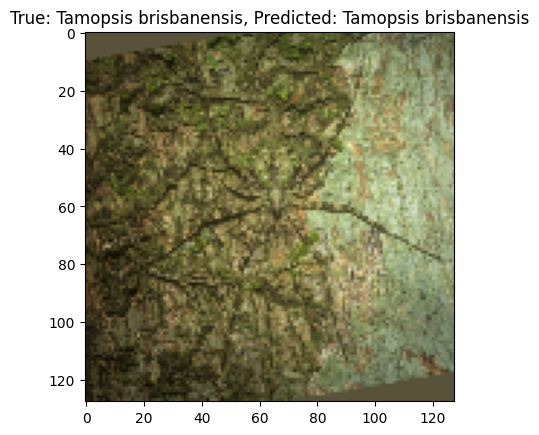

In [116]:
test_sample(3)